# 0. Imports & inputs

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.analytic_solar_cells.diode_equation import iv_2diode
from solcore.analytic_solar_cells.IV import iv_multijunction
from solcore.solar_cell_solver import default_options, solar_cell_solver
import pprint
import os
from datetime import datetime
import scipy.constants as const
import pvlib
from scipy.constants import Boltzmann, e

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# define the random seed for reproducibility
np.random.seed(666)

# define the number of IV curves to simulate and validate
num_curves = 3
# define the module area
module_area = 2 # m2
# define the number of cells in series and parallel
num_s_cells = 72
num_p_cells = 2

# define the range of Rs, Rsh, J01 J02, IL, T for the simulation
Rsmin = 0.1  # Ohm, from the modules I have
Rshmin = 200  # Ohm, from the modules I have
Rsmax = 0.4  # Ohm, from the modules I have
Rshmax = 1200  # Ohm, from the modules I have
J01min = 1e-14  # A/m2, from PV education range
J01max = 1e-8  # A/m2, from PV education range
J02min = 1e-12  # A/m2, from PV education range
J02max = 1e-6  # A/m2, from PV education range
ILmin = 8  # A/m2, from the modules I have
ILmax = 15  # A/m2, from the modules I have
Tmin = 273  # K, from the modules I have
Tmax = 343  # K, from the modules I have
N_param = 1000 # parameter sample size

# print out the default options
print("Default options:")
# Pretty‑print the entire defaults dict:
pprint.pprint(default_options)

# define the folder to save data
module_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_module"
# system_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\25_05_26_Results"
system_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system"

# define the number of modules within the system
num_modules = 10
# define the number of systems to simulate
num_systems = 1000

# physical constants
k = const.Boltzmann  # J/K
q = const.e  # C

# define the function to calculate the I0 at MPPT
def calc_I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def calc_IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL

Default options:
State([('T_ambient', 298),
       ('T', 298),
       ('wavelength',
        array([3.000e-07, 3.060e-07, 3.120e-07, 3.180e-07, 3.240e-07, 3.300e-07,
       3.360e-07, 3.420e-07, 3.480e-07, 3.540e-07, 3.600e-07, 3.660e-07,
       3.720e-07, 3.780e-07, 3.840e-07, 3.900e-07, 3.960e-07, 4.020e-07,
       4.080e-07, 4.140e-07, 4.200e-07, 4.260e-07, 4.320e-07, 4.380e-07,
       4.440e-07, 4.500e-07, 4.560e-07, 4.620e-07, 4.680e-07, 4.740e-07,
       4.800e-07, 4.860e-07, 4.920e-07, 4.980e-07, 5.040e-07, 5.100e-07,
       5.160e-07, 5.220e-07, 5.280e-07, 5.340e-07, 5.400e-07, 5.460e-07,
       5.520e-07, 5.580e-07, 5.640e-07, 5.700e-07, 5.760e-07, 5.820e-07,
       5.880e-07, 5.940e-07, 6.000e-07, 6.060e-07, 6.120e-07, 6.180e-07,
       6.240e-07, 6.300e-07, 6.360e-07, 6.420e-07, 6.480e-07, 6.540e-07,
       6.600e-07, 6.660e-07, 6.720e-07, 6.780e-07, 6.840e-07, 6.900e-07,
       6.960e-07, 7.020e-07, 7.080e-07, 7.140e-07, 7.200e-07, 7.260e-07,
       7.320e-07, 7.380e-07, 7.

# 1. Create dummy system from simulated modules

idea: try to calculate hte average value for each parameter and store it into the folder

In [ ]:
# define a counter to keep track of the number of systems created
system_counter = 0
# loop through the number of systems to create
for i in range(num_systems):
    # for each folder in the dummy module folder, randomly select N modules to save in the dummy system folder
    if os.path.exists(module_folder): # if the module folder is found
        # randomly select num_modules folders from hte module folder to create a dummy system folder
        module_folders = os.listdir(module_folder) # get the list of folders in the module folder
        # exclude any folder that include the word "Results"
        module_folders = [folder for folder in module_folders if "Results" not in folder] # filter out folders with "Results"
        # check if the number of folders is less than num_modules
        if len(module_folders) < num_modules:
            print("The number of folders in the module folder is less than the number of modules to be selected.")
            num_modules = len(module_folders) # set num_modules to the number of folders in the module folder
        # check if the number of folders is greater than num_modules
        if len(module_folders) > num_modules:  # check if the number of folders is greater than num_modules
            selected_modules = np.random.choice(module_folders, num_modules, replace=False) # randomly select num_modules
        else:
            selected_modules = module_folders  # use all available folders if less than num_modules
        # create a new folder for the dummy system
        new_system_folder = os.path.join(system_folder, "dummy_system_" + datetime.now().strftime("%Y%m%d_%H%M%S")) # create a new folder for the dummy system
        if not os.path.exists(new_system_folder): # check if the system folder exists
            os.makedirs(new_system_folder) # create the system folder
        # copy the selected module folders to the dummy system folder
        for module in selected_modules: # for each selected module
            module_path = os.path.join(module_folder, module) # get the path of the module folder
            dest_path = os.path.join(new_system_folder, module)   # destination path for this module
            if os.path.exists(module_path): # if the module folder exists
                # copy the module folder to the dummy system folder
                os.system(f'xcopy /E /I /Y "{module_path}" "{dest_path}"')
            else:
                print("The module folder does not exist: ", module_path)
    else: # if the module folder is not found
        print("The module folder does not exist: ", module_folder) # print out the error message

# 2. Mismatch loss error calculation

## 2.1. True mismatch from simulation

### 2.1.1. Solar Edge case

In [ ]:
# 2.1.1. Solar Edge case - Print all non-empty CSVs in only the first module of the first system
for system in os.listdir(system_folder): # for each system in the system folder
    if "Results" in system: # skip any folder that include the word "Results"
        continue # if so, skip to the next system
    system_path = os.path.join(system_folder, system) # get the path of the system folder
    if os.path.isdir(system_path): # check if the path is a directory
        print("System folder: ", system_path) # print out the system folder path
        # create a Pmax value to record the sum of Pmax values of each modules
        Pmax_sum = 0
        # loop through the folders in the system folder
        for module in os.listdir(system_path):
            # scan the files in the module folder
            module_path = os.path.join(system_path, module)
            if not os.path.isdir(module_path): # check if the path is a directory
                continue # if not, skip to the next module
            for file in os.listdir(module_path):
                # check if the file is a CSV file
                if file.endswith("table.csv"):
                    # get the path of the CSV file
                    csv_path = os.path.join(module_path, file)
                    # read the CSV file into a pandas dataframe
                    df = pd.read_csv(csv_path)
                    # for the first column, they are all text, remove any $, _, {, }
                    df.iloc[:, 0] = df.iloc[:, 0].str.replace("$", "").str.replace("_", "").str.replace("{", "").str.replace("}", "")
                    # rewrite it as a dictionary
                    df_dict = df.set_index(df.columns[0]).T.to_dict(orient='records')[0]
                    # extract the Pmax
                    Pmax = df_dict["Pmax"]
                    # add the Pmax to the sum
                    Pmax_sum += Pmax
        # print out hte final Pmax value
        print("Pmax value for system ", system, " is: ", Pmax_sum)
        # if there is no file as Pmax.txt
        if not os.path.exists(os.path.join(system_path, "Pmax.txt")):
            # create a new file to save the Pmax value
            with open(os.path.join(system_path, "Pmax.txt"), "w") as f:
                f.write("Pmax value for system " + system + " is: " + str(Pmax_sum) + "\n")
        else:
            # if the file exists, overwrite the first line with the new Pmax value
            with open(os.path.join(system_path, "Pmax.txt"), "r+") as f:
                lines = f.readlines()
                lines[0] = "Pmax value for system " + system + " is: " + str(Pmax_sum) + "\n"
                f.seek(0)
                f.writelines(lines)
                
                    

System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105839
Pmax value for system  dummy_system_20250528_105839  is:  3640.4700000000003
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105840
Pmax value for system  dummy_system_20250528_105840  is:  3721.4
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105841
Pmax value for system  dummy_system_20250528_105841  is:  4028.67
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105842
Pmax value for system  dummy_system_20250528_105842  is:  7540.97
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_sy

### 2.1.2. Series connection case

System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105839
Pmax value for system  dummy_system_20250528_105839  is:  3342.1235466133153
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105840
Pmax value for system  dummy_system_20250528_105840  is:  3434.843936123118
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105841
Pmax value for system  dummy_system_20250528_105841  is:  3711.9203308934307
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105842
Pmax value for system  dummy_system_20250528_105842  is:  6540.46210615915
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\

KeyboardInterrupt: 

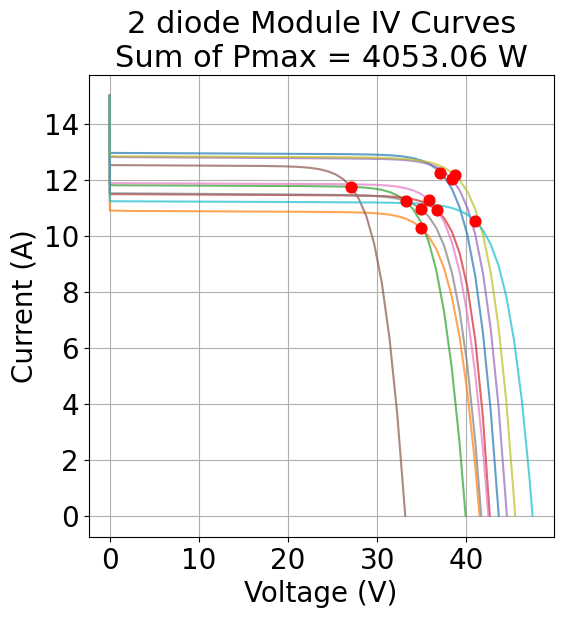

In [ ]:
# ...existing code...
for system in os.listdir(system_folder): # for each system in the system folder
    if "Results" in system: # skip any folder that include the word "Results"
        continue # if so, skip to the next system
    system_path = os.path.join(system_folder, system) # get the path of the system folder
    if os.path.isdir(system_path): # check if the path is a directory
        print("System folder: ", system_path) # print out the system folder path
        # create an empty pd.DataFrame to store the data
        df_series = pd.DataFrame()
        # store individual IV curves for plotting
        individual_IVs = []
        # loop through the folders in the system folder
        for module in os.listdir(system_path):
            # scan the files in the module folder
            module_path = os.path.join(system_path, module)
            if not os.path.isdir(module_path): # check if the path is a directory
                continue # if not, skip to the next module
            for file in os.listdir(module_path):
                # check if the file is a CSV file
                if file.endswith("data.csv"):
                    # read the csv file into a pandas dataframe
                    df = pd.read_csv(os.path.join(module_path, file))
                    # add the module name to the column names if it is V
                    if "V" in df.columns:
                        df.rename(columns=lambda x: module + "_" + x if x == "V" else x, inplace=True)
                    # set the I column as the index
                    df.set_index("I", inplace=True)
                    # add the voltage up
                    df_series = pd.concat([df_series, df], axis=1)
                    # store for plotting
                    individual_IVs.append((df.index.values, df[module + "_V"].values, module))
        # sum over the voltage columns to get the total voltage
        voltage_cols = [col for col in df_series.columns if col.endswith("_V")]
        df_combined = pd.DataFrame(index=df_series.index)
        df_combined["V_total"] = df_series[voltage_cols].sum(axis=1)
        df_combined["I"] = df_series.index
        df_combined["P"] = df_combined["V_total"] * df_combined["I"]
        # peak the maximum power point Vmpp and Impp
        Pmax = df_combined["P"].max()
        print("Pmax value for system ", system, " is: ", Pmax)
        # find the index of the maximum power point
        max_index = df_combined["P"].idxmax()
        # get the Vmpp and Impp values
        Vmpp = df_combined.loc[max_index, "V_total"]
        Impp = df_combined.loc[max_index, "I"]

        # Plot individual IV curves only
        # Plot individual IV curves only, with MPP marked and sum of Pmax in title
        plt.figure(figsize=figure_size)
        Pmax_sum = 0  # To accumulate the sum of Pmax for all modules
        for I_vals, V_vals, module in individual_IVs:
            plt.plot(V_vals, I_vals, alpha=0.7, label=f"{module} IV")
            # Calculate MPP for this module
            P_vals = V_vals * I_vals
            mpp_idx = np.argmax(P_vals)
            plt.scatter(V_vals[mpp_idx], I_vals[mpp_idx], color='red', s=60, marker='o', zorder=5)
            Pmax_sum += P_vals[mpp_idx]
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title(f"2 diode Module IV Curves\nSum of Pmax = {round(Pmax_sum, 2)} W", fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        # plt.legend(fontsize=10, loc='best', ncol=2)
        plt.grid()
        plt.savefig(os.path.join(system_path, "individual_IV_curves.png"), dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()

        # Plot combined IV curve only
        plt.figure(figsize=figure_size)
        plt.plot(df_combined["V_total"], df_combined["I"], label="Combined IV curve", color='black', linewidth=2)
        plt.scatter(Vmpp, Impp, color='red', label="MPPT", s=100, marker='o')
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title("Combined IV Curve\nPmax=" + str(round(Pmax)) + 'W', fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.legend(fontsize=10, loc='best')
        plt.grid()
        plt.savefig(os.path.join(system_path, "combined_IV_curve.png"), dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()

        # ...rest of your code for writing Pmax.txt...
        # write the Pmax value to a text file
        if not os.path.exists(os.path.join(system_path, "Pmax.txt")):
            # create a new file to save the Pmax value
            with open(os.path.join(system_path, "Pmax.txt"), "w") as f:
                f.write("Pmax value for system " + system + " is: " + str(Pmax) + "\n")
        else:
            # if the file exists, write the Pmax value as the second line
            pmax_line = "Pmax value for system " + system + " is: " + str(Pmax) + "\n"
            pmax_path = os.path.join(system_path, "Pmax.txt")
            with open(pmax_path, "r+") as f:
                lines = f.readlines()
                if len(lines) < 2:
                    # If there is only one line, append the second line
                    lines.append(pmax_line)
                else:
                    # Replace the second line
                    lines[1] = pmax_line
                f.seek(0)
                f.writelines(lines)
                f.truncate()


## 2.2. Mismatch from reconstruction of the simulated IV

### 2.2.1. Calculating the Pmax for both series and solar edge

In [ ]:
# ...existing code...

# 2.2.1. Calculating the Pmax for both series and solar edge
for system in os.listdir(system_folder):  # for each system in the system folder
    if "Results" in system:  # skip any folder that include the word "Results"
        continue  # if so, skip to the next system
    system_path = os.path.join(system_folder, system)  # get the path of the system folder
    if os.path.isdir(system_path):  # check if the path is a directory
        print("System folder: ", system_path)  # print out the system folder path
        # create a Pmax value to record the sum of Pmax values of each modules
        Pmax_sum_reconstructed = 0
        # create a df to add the data up in series
        df_series = pd.DataFrame()
        # lists to store MPPs for scatter plot
        mpp_v_list = []
        mpp_i_list = []
        # lists to store all reconstructed and original IVs for all modules
        all_IVs = []
        all_orig_IVs = []
        module_names = []
        mpp_points = []
        # for each folder in the system folder
        for module in os.listdir(system_path):
            # scan the files in the module folder
            module_path = os.path.join(system_path, module)
            # check if it is a folder
            if os.path.isdir(module_path):
                # read the csv file named 'IV_curve_table.csv'
                for file in os.listdir(module_path):
                    # check if the file is a CSV file
                    if file.endswith("IV_curve_table.csv"):
                        # read the csv file into a pandas dataframe
                        df = pd.read_csv(os.path.join(module_path, file))
                        # for the first column, they are all text, remove any $, _, {, }
                        df.iloc[:, 0] = df.iloc[:, 0].str.replace("$", "").str.replace("_", "").str.replace("{", "").str.replace("}", "")
                        # rewrite it as a dictionary
                        df_dict = df.set_index(df.columns[0]).T.to_dict(orient='records')[0]

                        # IV curve reconstruction using single diode model
                        vth = k * df_dict["T"] / q
                        I0_value = calc_I0(df_dict["Imp"], df_dict["Vmp"], df_dict["Rs"], df_dict["Rsh"], df_dict["n"], num_s_cells, vth)
                        IL_value = calc_IL(df_dict["Imp"], df_dict["Vmp"], df_dict["Rs"], df_dict["Rsh"], df_dict["n"], num_s_cells, vth, I0_value)
                        I_reconstructed = np.linspace(0, 15, 1000)
                        V_reconstructed = pvlib.pvsystem.v_from_i(
                            current=I_reconstructed,
                            photocurrent=IL_value,
                            saturation_current=I0_value,
                            resistance_series=df_dict["Rs"],
                            resistance_shunt=df_dict["Rsh"],
                            nNsVth=df_dict["n"] * num_s_cells * vth,
                            method='lambertw'
                        )
                        V_reconstructed[V_reconstructed < 0] = 0

                        # find the mpp of the reconstructed IV curve
                        P_reconstructed = I_reconstructed * V_reconstructed
                        mpp_idx = np.argmax(P_reconstructed)
                        V_mpp = V_reconstructed[mpp_idx]
                        I_mpp = I_reconstructed[mpp_idx]
                        Pmax_reconstructed = P_reconstructed[mpp_idx]
                        Pmax_sum_reconstructed += Pmax_reconstructed

                        # add the reconstructed IV curve to the df_series
                        df_series[module + "_V"] = V_reconstructed
                        df_series.index = I_reconstructed

                        # store MPP for scatter plot
                        mpp_v_list.append(V_mpp)
                        mpp_i_list.append(I_mpp)
                        mpp_points.append((V_mpp, I_mpp))

                        # store for all-IV plot
                        all_IVs.append((V_reconstructed, I_reconstructed, module))
                        module_names.append(module)

                        # Try to load original IV curve for this module
                        orig_iv_path = os.path.join(module_path, "IV_curve_data.csv")
                        orig_V = None
                        orig_I = None
                        if os.path.exists(orig_iv_path):
                            df_orig = pd.read_csv(orig_iv_path)
                            orig_V = df_orig["V"].values
                            orig_I = df_orig["I"].values
                            all_orig_IVs.append((orig_V, orig_I, module))
                        else:
                            all_orig_IVs.append((None, None, module))

                        # Plot original vs reconstructed IV curve for this module (if original IV data exists)
                        plt.figure(figsize=figure_size)
                        if orig_V is not None and orig_I is not None:
                            plt.plot(orig_V, orig_I, 'b-', label="Original IV")
                            plt.scatter(df_dict["Vmp"], df_dict["Imp"], color='red', label="MPP")
                        plt.plot(V_reconstructed, I_reconstructed, 'r--', label="Reconstructed IV")
                        plt.scatter(V_mpp, I_mpp, color='red', s=60, zorder=5)  # Mark reconstructed MPP
                        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
                        plt.ylabel("Current (A)", fontsize=axis_label_size)
                        plt.title(f"Module {module} IV: Original vs Reconstructed", fontsize=title_size)
                        plt.legend(fontsize=12)
                        plt.grid()
                        plt.savefig(os.path.join(module_path, "IV_compare.png"), dpi=300, bbox_inches='tight')
                        plt.close()

        # Plot all reconstructed IV curves for all modules in one plot, with MPPs and sum of Pmax in the title
        plt.figure(figsize=figure_size)
        color_map = plt.get_cmap('tab10')
        for idx, (V, I, module) in enumerate(all_IVs):
            color = color_map(idx % 10)
            plt.plot(V, I, '--', color=color, label=f"{module} (recon)")
            # Mark MPP for each module
            V_mpp, I_mpp = mpp_points[idx]
            plt.scatter(V_mpp, I_mpp, color=color, s=60, edgecolor='k', zorder=5)
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title(f"All Module Reconstructed IV Curves\nSum of Pmax = {round(Pmax_sum_reconstructed, 2)} W", fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.grid()
        # plt.legend(fontsize=10, loc='best', ncol=2)
        plt.savefig(os.path.join(system_path, "all_modules_reconstructed_IV_curves.png"), dpi=300, bbox_inches='tight')
        plt.close()
        # ...existing code...

        # Plot all original vs reconstructed IV curves for all modules in one plot, matching colors and marking MPPs with same color as IV
        plt.figure(figsize=figure_size)
        for idx, module in enumerate(module_names):
            color = color_map(idx % 10)
            # Plot original if available
            orig_V, orig_I, _ = all_orig_IVs[idx]
            if orig_V is not None and orig_I is not None:
                plt.plot(orig_V, orig_I, '-', alpha=0.7, color=color, label=f"{module} original")
            V, I, _ = all_IVs[idx]
            plt.plot(V, I, '--', alpha=0.7, color=color, label=f"{module} recon")
            # Mark reconstructed MPP with same color
            V_mpp, I_mpp = mpp_points[idx]
            plt.scatter(V_mpp, I_mpp, color=color, s=60, edgecolor='k', zorder=5)
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title(f"All Modules: Original vs Reconstructed IV Curves", fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.grid()
        # plt.legend(fontsize=10, loc='best', ncol=2)
        plt.savefig(os.path.join(system_path, "all_modules_original_vs_reconstructed_IV_curves.png"), dpi=300, bbox_inches='tight')
        plt.close()

        # open the text file in the system folder and write the results
        pmax_line = "Reconstructed solar edge case Pmax value for system " + system + " is: " + str(Pmax_sum_reconstructed) + "\n"
        pmax_path = os.path.join(system_path, "Pmax.txt")
        with open(pmax_path, "r+") as f:
            lines = f.readlines()
            if len(lines) < 3:
                # If less than 3 lines, append until there are 3 lines
                while len(lines) < 2:
                    lines.append("\n")
                lines.append(pmax_line)
            else:
                # Replace the third line
                lines[2] = pmax_line
            f.seek(0)
            f.writelines(lines)
            f.truncate()

        # sum over the voltage columns to get the total voltage
        voltage_cols = [col for col in df_series.columns if col.endswith("_V")]
        df_combined = pd.DataFrame(index=df_series.index)
        df_combined["V_total"] = df_series[voltage_cols].sum(axis=1)
        df_combined["I"] = df_series.index

        # calculate the power for the combined IV curve
        df_combined["P"] = df_combined["V_total"] * df_combined["I"]
        # peak the new Pmax value
        Pmax = df_combined["P"].max()
        print("Pmax value for system, reconstructed,series ", system, " is: ", Pmax)

        # plot the combined IV curve from reconstructed data using dashline
        plt.figure(figsize=figure_size)
        plt.plot(df_combined["V_total"], df_combined["I"], '--', label="Combined IV curve", color='black', linewidth=2)
        plt.scatter(df_combined["V_total"][df_combined["P"].idxmax()], df_combined["I"][df_combined["P"].idxmax()], color='red', label="MPPT", s=100, marker='o')
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title("Combined Reconstructed IV Curve\nPmax=" + str(round(Pmax)) + 'W', fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.legend(fontsize=10, loc='best')
        plt.grid()
        plt.savefig(os.path.join(system_path, "combined_reconstructed_IV_curve.png"), dpi=300, bbox_inches='tight')
        plt.close()

        # plot the reconstructed combined IV with original combined IV
        # Prepare to build the original combined IV
        original_voltages = []
        common_current = df_series.index  # Use the same current grid as reconstructed

        for idx, module in enumerate(module_names):
            orig_V, orig_I, _ = all_orig_IVs[idx]
            if orig_V is not None and orig_I is not None:
                # Interpolate original voltage to the common current grid
                v_interp = np.interp(common_current, orig_I, orig_V, left=0, right=0)
                original_voltages.append(v_interp)
            else:
                # If missing, fill with zeros
                original_voltages.append(np.zeros_like(common_current))

        if original_voltages:
            V_total_original = np.sum(original_voltages, axis=0)
            # Calculate power and MPP for original combined IV
            P_original = V_total_original * common_current
            idx_mpp_orig = np.argmax(P_original)
            Vmpp_orig = V_total_original[idx_mpp_orig]
            Impp_orig = common_current[idx_mpp_orig]
            Pmax_orig = P_original[idx_mpp_orig]
        else:
            V_total_original = None
            Pmax_orig = None

        # Plot both combined IV curves
        plt.figure(figsize=figure_size)
        # Reconstructed combined IV (dashed)
        plt.plot(
            df_combined["V_total"], df_combined["I"], '--',
            label="Reconstructed Combined IV", color='black', linewidth=2
        )
        # Original combined IV (solid)
        if V_total_original is not None:
            plt.plot(
                V_total_original, common_current, '-', 
                label="Original Combined IV", color='blue', linewidth=2
            )
        # Scatter MPPs with Pmax in legend
        recon_mpp = plt.scatter(
            df_combined["V_total"][df_combined["P"].idxmax()],
            df_combined["I"][df_combined["P"].idxmax()],
            color='red', s=100, marker='o', label=f"Reconstructed MPP (Pmax={Pmax:.2f} W)"
        )
        if V_total_original is not None:
            orig_mpp = plt.scatter(
                Vmpp_orig, Impp_orig, color='blue', s=100, marker='o', label=f"Original MPP (Pmax={Pmax_orig:.2f} W)"
            )
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title("Combined IV Curves: Original vs Reconstructed", fontsize=title_size)
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.legend(fontsize=12, loc='upper right')
        plt.ylim(0, 25)
        plt.xlim(0, )
        plt.grid()
        plt.savefig(os.path.join(system_path, "combined_original_vs_reconstructed_IV_curve.png"), dpi=300, bbox_inches='tight')
        plt.close()
        # ...existing code...


        # write this result to the text file as the fourth line
        pmax_line = "Reconstructed series connection case Pmax value for system " + system + " is: " + str(Pmax) + "\n"
        with open(pmax_path, "r+") as f:
            lines = f.readlines()
            if len(lines) < 4:
                # If less than 4 lines, append until there are 4 lines
                while len(lines) < 3:
                    lines.append("\n")
                lines.append(pmax_line)
            else:
                # Replace the fourth line
                lines[3] = pmax_line
            f.seek(0)
            f.writelines(lines)
            f.truncate()

        # Scatter plot of MPPs for all modules in this system
        plt.figure(figsize=figure_size)
        plt.scatter(mpp_v_list, mpp_i_list, color='red', s=60)
        plt.xlabel("Voltage (V)", fontsize=axis_label_size)
        plt.ylabel("Current (A)", fontsize=axis_label_size)
        plt.title(f"Module MPPs", fontsize=title_size)
        plt.grid()
        plt.ylim(0, 15)
        plt.xlim(0, )
        plt.xticks(fontsize=axis_num_size)
        plt.yticks(fontsize=axis_num_size)
        plt.savefig(os.path.join(system_path, "module_mpp_scatter.png"), dpi=300, bbox_inches='tight')
        plt.close()

System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105839
Pmax value for system, reconstructed,series  dummy_system_20250528_105839  is:  3399.2459747320627
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105840
Pmax value for system, reconstructed,series  dummy_system_20250528_105840  is:  3496.1353778788907
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105841
Pmax value for system, reconstructed,series  dummy_system_20250528_105841  is:  3746.1482585829963
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105842
Pmax value for system, reconstructed,series  dummy_system_20250528_105842  is:  6607.1842941491

### 2.2.2. Summarise the results

In [ ]:
# 2.1.3. Calculate the mismatch loss and create a summary table
results = []

for system in os.listdir(system_folder):  # for each system in the system folder
    if "Results" in system:  # skip any folder that include the word "Results"
        continue  # if so, skip to the next system
    system_path = os.path.join(system_folder, system)  # get the path of the system folder
    if os.path.isdir(system_path):  # check if the path is a directory
        print("System folder: ", system_path)  # print out the system folder path
        # read the text file in the folder
        with open(os.path.join(system_path, "Pmax.txt"), "r") as f:
            lines = f.readlines()
            # extract the P_solar_edge from the first line
            P_solar_edge = float(lines[0].split(":")[1].strip())
            print("P_solar_edge: ", P_solar_edge)
            # extract the Pmax from the second line
            P_series = float(lines[1].split(":")[1].strip())
            print("P_series: ", P_series)
            # extract the Pmax from the third line being reconstructed soalr edge case
            P_reconstructed_solar_edge = float(lines[2].split(":")[1].strip())
            print("P_reconstructed_solar_edge: ", P_reconstructed_solar_edge)
            # extract the Pmax from the fourth line being reconstructed series case
            P_reconstructed_series = float(lines[3].split(":")[1].strip())
            print("P_reconstructed_series: ", P_reconstructed_series)
            # calculate the percentage difference
            mismatch = (P_solar_edge - P_series) / P_solar_edge * 100
            print("Mismatch: ", mismatch, "%")
            # calculate the percentage difference for reconstructed solar edge case
            mismatch_reconstructed_solar_edge = (P_reconstructed_solar_edge - P_reconstructed_series) / P_reconstructed_solar_edge * 100
            print("Mismatch reconstructed solar edge: ", mismatch_reconstructed_solar_edge, "%")
            # append the results
            results.append({
                "system_name": system,
                "Psolar_edge_true": P_solar_edge,
                "P_series_true": P_series,
                "true_mismatch_loss (%)": mismatch,
                "P_reconstructed_solar_edge": P_reconstructed_solar_edge,
                "P_reconstructed_series": P_reconstructed_series,
                "reconstructed_mismatch_loss (%)": mismatch_reconstructed_solar_edge
            })

# Create DataFrame and display/save
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv(os.path.join(system_folder, "mismatch_loss_summary.csv"), index=False)


System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105839
P_solar_edge:  3640.4700000000003
P_series:  3342.1235466133153
P_reconstructed_solar_edge:  3640.8086730282116
P_reconstructed_series:  3399.2459747320627
Mismatch:  8.195272956148106 %
Mismatch reconstructed solar edge:  6.634863844554381 %
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105840
P_solar_edge:  3721.4
P_series:  3434.843936123118
P_reconstructed_solar_edge:  3721.6628937358696
P_reconstructed_series:  3496.1353778788907
Mismatch:  7.7002220636556675 %
Mismatch reconstructed solar edge:  6.059858786151113 %
System folder:  C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_system\dummy_system_20250528_105841
P_solar_edge:  4028.67
P_series:  3711.9203308934307
P_reconstructed_s

# 3. Error of mismatch loss summary (only run this session if the dummy system results are ready)

R2 score:  0.8251191826090859
RMSE:  1.9014972251993014


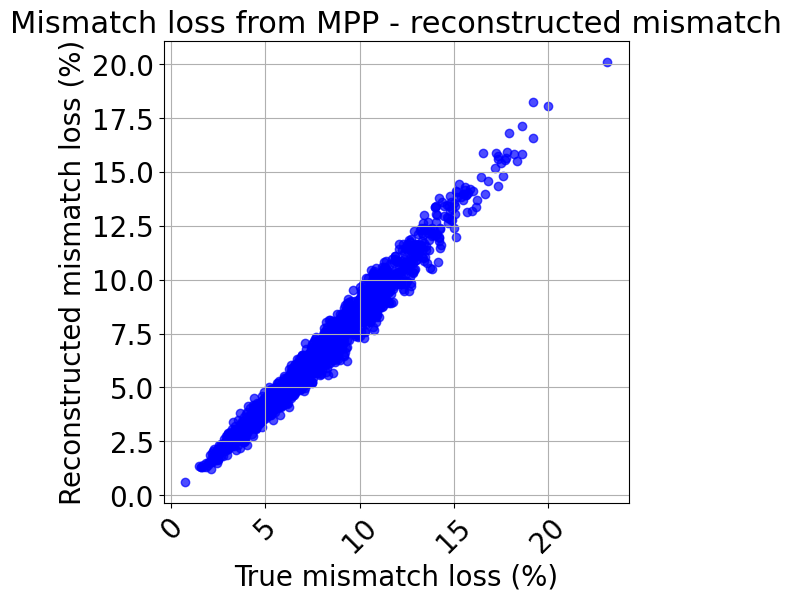

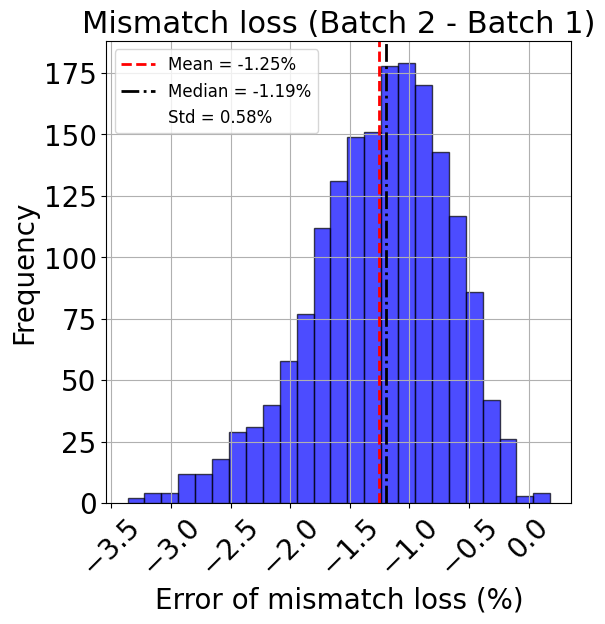

Mean error of mismatch loss:  -1.251324493673932
Standard deviation of error of mismatch loss:  0.5795456338892481


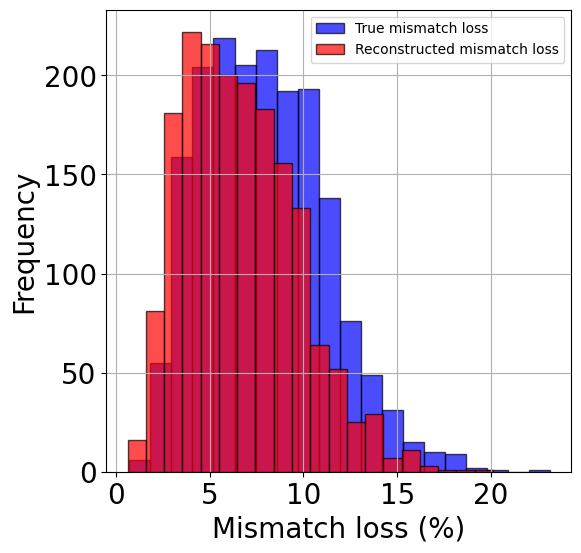

In [ ]:
# read the csv file in the system folder
df = pd.read_csv(os.path.join(system_folder, "mismatch_loss_summary.csv"))
# add another column bing the difference between P_reconstructed_solar_edge and P_reconstructed_series
df['Error of mismatch loss (%)'] = df['reconstructed_mismatch_loss (%)'] - df['true_mismatch_loss (%)']

# calculate the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(df['true_mismatch_loss (%)'], df['reconstructed_mismatch_loss (%)'])
print("R2 score: ", r2)
# calcualte the RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(df['true_mismatch_loss (%)'], df['reconstructed_mismatch_loss (%)'])
print("RMSE: ", rmse)

# plot true mismatch loss vs reconstructed mismatch loss
plt.figure(figsize=figure_size)
plt.scatter(df['true_mismatch_loss (%)'], df['reconstructed_mismatch_loss (%)'], color='blue', alpha=0.7)
plt.xlabel('True mismatch loss (%)', fontsize=axis_label_size)
plt.ylabel('Reconstructed mismatch loss (%)', fontsize=axis_label_size)
plt.title('Mismatch loss from MPP - reconstructed mismatch', fontsize=title_size)
plt.xticks(fontsize=axis_num_size, rotation=45)
plt.yticks(fontsize=axis_num_size)
plt.grid()
# plt.savefig(os.path.join(system_folder, "mismatch_loss_scatter.png"), dpi=300, bbox_inches='tight')
plt.show()


# plot a histogram of the error of mismatch loss
plt.figure(figsize=figure_size)
plt.hist(df['Error of mismatch loss (%)'], bins=25, color='blue', alpha=0.7, edgecolor='black')

# Calculate mean and median
mean_error = df['Error of mismatch loss (%)'].mean()
median_error = df['Error of mismatch loss (%)'].median()
# calculate the standard deviation
std_error = df['Error of mismatch loss (%)'].std()

# Plot vertical lines for mean and median
plt.axvline(mean_error, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_error:.2f}%")
plt.axvline(median_error, color='black', linestyle='-.', linewidth=2, label=f"Median = {median_error:.2f}%")
plt.axvline(mean_error + std_error, color='green', linestyle=':', linewidth=2, label=f"Std = {std_error:.2f}%", alpha=0)
# plt.axvline(mean_error - std_error, color='green', linestyle=':', linewidth=2)
plt.xlabel('Error of mismatch loss (%)', fontsize=axis_label_size)
plt.ylabel('Frequency', fontsize=axis_label_size)
plt.title('Mismatch loss (Batch 2 - Batch 1)', fontsize=title_size)
plt.xticks(fontsize=axis_num_size, rotation=45)
plt.yticks(fontsize=axis_num_size)
plt.legend(fontsize=12)
plt.grid()
# plt.savefig(os.path.join(system_folder, "error_of_mismatch_loss.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# calculate and print the mean and std of the error of mismatch loss
mean_error = df['Error of mismatch loss (%)'].mean()
std_error = df['Error of mismatch loss (%)'].std()
print("Mean error of mismatch loss: ", mean_error)
print("Standard deviation of error of mismatch loss: ", std_error)

# plot a histogram of the true mismatch loss and the reconstructed mismatch loss together
plt.figure(figsize=figure_size)
plt.hist(df['true_mismatch_loss (%)'], bins=20, color='blue', alpha=0.7, edgecolor='black', label='True mismatch loss')
plt.hist(df['reconstructed_mismatch_loss (%)'], bins=20, color='red', alpha=0.7, edgecolor='black', label='Reconstructed mismatch loss')
plt.xlabel('Mismatch loss (%)', fontsize=axis_label_size)
plt.ylabel('Frequency', fontsize=axis_label_size)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
# plt.title('Mismatch loss from MPP - true vs reconstructed', fontsize=title_size)
plt.legend(fontsize=10, loc='upper right')
plt.grid()
# plt.savefig(os.path.join(system_folder, "mismatch_loss_histogram.png"), dpi=300, bbox_inches='tight')
plt.show()



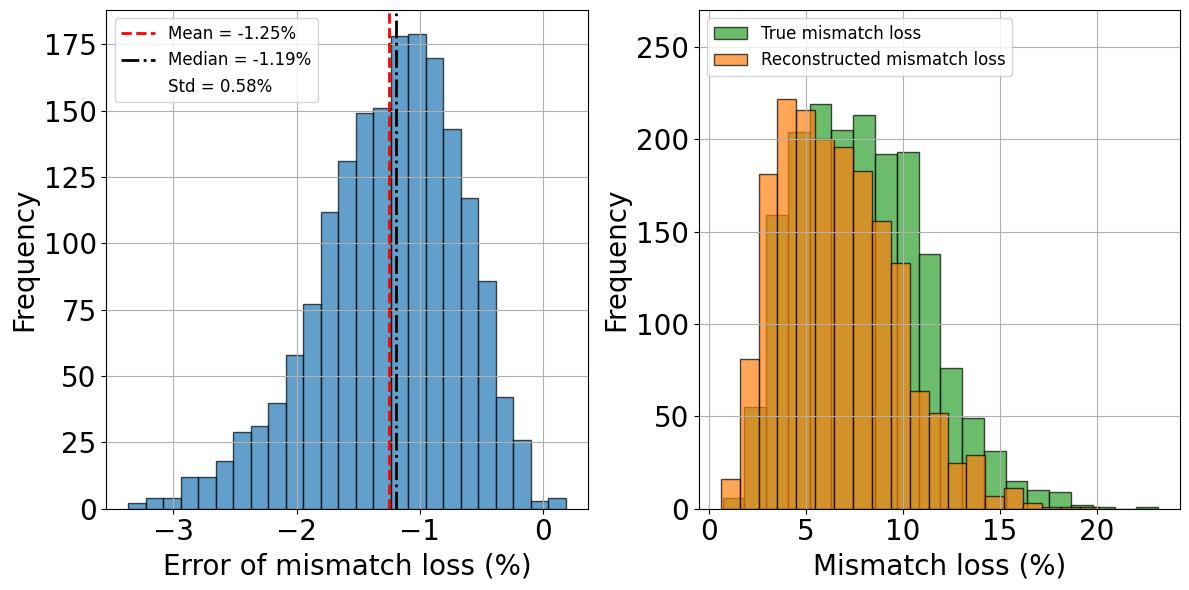

Mean error of mismatch loss:  -1.251324493673932
Standard deviation of error of mismatch loss:  0.5795456338892481


In [ ]:
# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(long_hoz_figsize[0], figure_size[1]))

# --- First subplot: Histogram of the error of mismatch loss ---
axes[0].hist(df['Error of mismatch loss (%)'], bins=25, alpha=0.7, edgecolor='black')

# Calculate mean, median, and std for the first subplot
mean_error = df['Error of mismatch loss (%)'].mean()
median_error = df['Error of mismatch loss (%)'].median()
std_error = df['Error of mismatch loss (%)'].std()

# Plot vertical lines for mean and median
axes[0].axvline(mean_error, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_error:.2f}%")
axes[0].axvline(median_error, color='black', linestyle='-.', linewidth=2, label=f"Median = {median_error:.2f}%")
axes[0].axvline(mean_error + std_error, color='green', linestyle=':', linewidth=2, label=f"Std = {std_error:.2f}%", alpha=0) # Hidden line for legend
axes[0].set_xlabel('Error of mismatch loss (%)', fontsize=axis_label_size)
axes[0].set_ylabel('Frequency', fontsize=axis_label_size)
# axes[0].set_title('Mismatch loss (Batch 2 - Batch 1)', fontsize=title_size)
axes[0].tick_params(axis='x', labelsize=axis_num_size)
axes[0].tick_params(axis='y', labelsize=axis_num_size)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# --- Second subplot: Histogram of true vs reconstructed mismatch loss ---
axes[1].hist(df['true_mismatch_loss (%)'], bins=20, alpha=0.7, edgecolor='black', label='True mismatch loss', color='C2')
axes[1].hist(df['reconstructed_mismatch_loss (%)'], bins=20, alpha=0.7, edgecolor='black', label='Reconstructed mismatch loss', color='C1')
axes[1].set_xlabel('Mismatch loss (%)', fontsize=axis_label_size)
axes[1].set_ylabel('Frequency', fontsize=axis_label_size)
axes[1].tick_params(axis='x', labelsize=axis_num_size)
axes[1].tick_params(axis='y', labelsize=axis_num_size)
# axes[1].set_title('Mismatch loss from MPP - true vs reconstructed', fontsize=title_size)
axes[1].legend(fontsize=12, loc='upper left')
axes[1].grid(True)
# set y axis limit
axes[1].set_ylim(0, 270)  # Adjust as needed for better visibility
# --- Display the combined plot ---
plt.tight_layout()
# plt.savefig(os.path.join(system_folder, "combined_mismatch_histograms.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# calculate and print the mean and std of the error of mismatch loss
mean_error = df['Error of mismatch loss (%)'].mean()
std_error = df['Error of mismatch loss (%)'].std()
print("Mean error of mismatch loss: ", mean_error)
print("Standard deviation of error of mismatch loss: ", std_error)

In [ ]:
import pandas as pd
import os

# File path
file_path = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Code\25_04_03_module_diode_activation_LTSpice\25_04_04_bypass.xlsx"

# Check if file exists
if os.path.exists(file_path):
    print(f"File exists: {file_path}")
    
    # Get all sheet names
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    print(f"\nNumber of sheets: {len(sheet_names)}")
    print(f"Sheet names: {sheet_names}")
    
    # For each sheet, get basic info
    for i, sheet_name in enumerate(sheet_names):
        print(f"\n--- Sheet {i+1}: '{sheet_name}' ---")
        try:
            # Read just the first few rows to understand structure
            df = pd.read_excel(file_path, sheet_name=sheet_name, nrows=5)
            
            print(f"Shape (first 5 rows): {df.shape}")
            print(f"Column names: {list(df.columns)}")
            
            # Show data types
            print("Column data types:")
            for col, dtype in df.dtypes.items():
                print(f"  {col}: {dtype}")
                
            # Show first few rows (just headers and first row)
            print("\nFirst few rows:")
            print(df.head(2))
            
        except Exception as e:
            print(f"Error reading sheet '{sheet_name}': {e}")
            
else:
    print(f"File does not exist: {file_path}")

In [ ]:
import pandas as pd
import numpy as np

# Read the Excel file and analyze its structure
file_path = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Code\25_04_03_module_diode_activation_LTSpice\25_04_04_bypass.xlsx"

# Get all sheet names
xl_file = pd.ExcelFile(file_path)
sheet_names = xl_file.sheet_names

print("Excel File Structure Analysis")
print("=" * 50)
print(f"File: {file_path}")
print(f"Number of sheets: {len(sheet_names)}")
print(f"Sheet names: {sheet_names}")
print()

# Analyze each sheet
sheet_info = {}

for sheet_name in sheet_names:
    print(f"SHEET: {sheet_name}")
    print("-" * 30)
    
    try:
        # Read the sheet
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Store basic info
        sheet_info[sheet_name] = {
            'shape': df.shape,
            'columns': list(df.columns),
            'dtypes': df.dtypes.to_dict(),
            'sample_data': df.head(8).to_dict('records')  # First 8 rows as sample
        }
        
        print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
        print(f"Columns: {list(df.columns)}")
        print()
        
        # Show data types
        print("Data types:")
        for col, dtype in df.dtypes.items():
            print(f"  {col}: {dtype}")
        print()
        
        # Show sample data (first 5 rows)
        print("Sample data (first 5 rows):")
        print(df.head(5).to_string(index=False))
        print()
        
        # Check for I-V curve related columns
        iv_indicators = []
        for col in df.columns:
            col_lower = str(col).lower()
            if any(keyword in col_lower for keyword in ['voltage', 'volt', 'v', 'current', 'curr', 'i', 'power', 'p']):
                iv_indicators.append(col)
        
        if iv_indicators:
            print(f"Potential I-V curve columns: {iv_indicators}")
        else:
            print("No obvious I-V curve columns detected")
        print()
        
        # Look for patterns in column names
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            print(f"Numeric columns: {numeric_cols}")
        print()
        
    except Exception as e:
        print(f"Error reading sheet {sheet_name}: {e}")
        sheet_info[sheet_name] = {'error': str(e)}
    
    print("=" * 50)
    print()

# Summary analysis
print("SUMMARY ANALYSIS")
print("=" * 50)

total_sheets = len(sheet_names)
readable_sheets = len([k for k, v in sheet_info.items() if 'error' not in v])

print(f"Successfully read {readable_sheets}/{total_sheets} sheets")
print()

# Look for common patterns across sheets
all_columns = []
for sheet, info in sheet_info.items():
    if 'columns' in info:
        all_columns.extend(info['columns'])

unique_columns = list(set(all_columns))
print(f"Unique column names across all sheets: {len(unique_columns)}")
print("Most common column patterns:")
for col in unique_columns:
    count = all_columns.count(col)
    if count > 1:
        print(f"  '{col}': appears in {count} sheets")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\z5183876\\OneDrive - UNSW\\Documents\\GitHub\\24_09_24_Solar_Edge\\Code\\25_04_03_module_diode_activation_LTSpice\\25_04_04_bypass.xlsx'